In [1]:
%pip install selenium
%pip install spacy networkx
%pip python -m spacy download es_core_news_md
%pip install networkx


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "python"



Note: you may need to restart the kernel to use updated packages.


# Librerías

In [149]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Ejercicio 1: RAG

## Base de datos Vectorial

## Base de datos de Grafos

In [150]:
def open_chrome(chromedriver_path="src/chromedriver.exe", headless=True):
    """Configura y devuelve el controlador de Selenium."""
    options = webdriver.ChromeOptions()
    if headless:
        options.add_argument("--headless")# Ejecutar en segundo plano
    service = Service(chromedriver_path)
    driver = webdriver.Chrome(service=service, options=options)
    return driver

def close_chrome(driver):
    driver.quit()

url_game = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges"
url_game_credits = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits"

### Extracción de la página principal: url_games

In [148]:
def extract_awards(driver, url):
    """Extrae premios y honores de la página principal de un juego."""
    driver.get(url)
    awards = []

    try:
        # # Espera a que el encabezado de premios esté presente
        # header_selector = "//h3[contains(text(), 'Awards & Honors')]"
        # WebDriverWait(driver, 10).until(
        #     EC.presence_of_element_located((By.XPATH, header_selector))
        # )

        # Busca los premios dentro del contenedor
        awards_selector = "//a[@class='ng-binding'][contains(@ng-href, '/boardgamehonor/')]"
        awards_elements = driver.find_elements(By.XPATH, awards_selector)

        # Extraer el texto de los premios
        awards = [award.text.strip() for award in awards_elements if award.text.strip()]
    except Exception as e:
        print(f"Error extracting awards: {e}")

    return awards


driver = open_chrome()
awards_data = extract_awards(driver, url_game)
print("Awards:", awards_data)
driver.quit()


Awards: ['2019 MinD-Spielepreis Complex Game Nominee', '2018 Juego del Año Recommended', '2018 International Gamers Award - General Strategy: Multi-player Winner', '2018 International Gamers Award - General Strategy: Multi-player Nominee', '2017 Meeples Choice Award Nominee']


### Extracción de la página: url_games_credits

In [144]:
def extract_game_credits_data(driver, url):
    """Extrae datos del juego desde la página de créditos."""
    driver.get(url)
    data = {}
    data['Name'] = "Rajas of the Ganges"
    data['Year'] = "2017"

    # try:
    #     # Nombre principal
    #     name_selector = "//span[@id='fullcredits-name']"
    #     name_element = WebDriverWait(driver, 10).until(
    #         EC.presence_of_element_located((By.XPATH, name_selector))
    #     )
    #     data["PrimaryName"] = name_element.text.strip()
    # except Exception as e:
    #     print(f"Error extracting primary name: {e}")
    #     data["PrimaryName"] = None

    # try:
    #     # Año de publicación
    #     year_selector = "//span[@id='fullcredits-yearpublished' or contains(text(), 'Year Released')]"
    #     year_element = WebDriverWait(driver, 10).until(
    #         EC.visibility_of_element_located((By.XPATH, year_selector))
    #     )
    #     data["YearReleased"] = year_element.text.strip()
    # except Exception as e:
    #     print(f"Error extracting year released: {e}")
    #     data["YearReleased"] = None

    try:
        # Nombres alternativos
        alternate_name_selector = "div[ng-repeat='name in creditsctrl.geekitem.data.item.alternatenames']"
        alternate_name_elements = driver.find_elements(By.CSS_SELECTOR, alternate_name_selector)
        data["AlternateNames"] = [name.text.strip() for name in alternate_name_elements if name.text.strip()]
    except Exception as e:
        print(f"Error extracting alternate names: {e}")
        data["AlternateNames"] = []

    try:
        # Categorías
        category_selector = "a.ng-binding[href*='/boardgamecategory/']"
        category_elements = driver.find_elements(By.CSS_SELECTOR, category_selector)
        data["Categories"] = [category.text.strip() for category in category_elements if category.text.strip()]
    except Exception as e:
        print(f"Error extracting categories: {e}")
        data["Categories"] = []

    return data

# Ejecución del script
driver = open_chrome()
game_data = extract_game_credits_data(driver, url_game_credits)
print(game_data)
driver.quit()


{'Name': 'Rajas of the Ganges', 'Year': '2017', 'AlternateNames': ['Ganges', 'I Ragià del Gange', "Raja's van de Ganges", 'Раджи Ганга', 'ガンジスの藩王', '갠지스의 라자'], 'Categories': ['Dice', 'Economic', 'Renaissance', 'Territory Building']}


In [97]:
def find_urls(driver, url, data):
    driver.get(url)
    urls = []
    selector = f'a.ng-binding[ng-href*="/boardgame{data}/"]'
    links = driver.find_elements(By.CSS_SELECTOR, selector)
    urls = [link.get_attribute('href') for link in links]
    return urls

driver = open_chrome()
url_designers = find_urls(driver, url_game_credits, 'designer')
url_artists = find_urls(driver, url_game_credits, 'artist')
url_publishers = find_urls(driver, url_game_credits, 'publisher')
url_family = find_urls(driver, url_game_credits, 'family')
close_chrome(driver)

In [98]:
url_designers, url_artists, url_publishers, url_family

(['https://boardgamegeek.com/boardgamedesigner/6940/inka-brand',
  'https://boardgamegeek.com/boardgamedesigner/6941/markus-brand'],
 ['https://boardgamegeek.com/boardgameartist/12484/dennis-lohausen'],
 ['https://boardgamegeek.com/boardgamepublisher/3490/huch',
  'https://boardgamegeek.com/boardgamepublisher/267/999-games',
  'https://boardgamegeek.com/boardgamepublisher/2366/devir',
  'https://boardgamegeek.com/boardgamepublisher/46544/dice-realm',
  'https://boardgamegeek.com/boardgamepublisher/917/dv-games',
  'https://boardgamegeek.com/boardgamepublisher/7496/egmont-polska',
  'https://boardgamegeek.com/boardgamepublisher/37681/fabrika-igr',
  'https://boardgamegeek.com/boardgamepublisher/12540/game-harbor',
  'https://boardgamegeek.com/boardgamepublisher/17130/hot-games',
  'https://boardgamegeek.com/boardgamepublisher/52507/nostalgia-iii',
  'https://boardgamegeek.com/boardgamepublisher/105/r-and-r-games'],
 ['https://boardgamegeek.com/boardgamefamily/22783/admin-better-descript

In [ ]:
# def get_data_by_issue(driver, issue, urls):
#     list = []
#     for url in urls:
#         driver.get(url)
#         # Construir el selector dinámicamente según el patrón (issue)
#         selector = f'a.ng-binding[ng-href*="/{issue}/"]'
#         # Encontrar todos los elementos que coincidan con el selector
#         element = driver.find_element(By.CSS_SELECTOR, selector)
#         # Extraer y retornar los textos de los elementos
#         name = element.text.strip()

#         dict = {'Name': name}#, 'Partner': partner, 'Award': award, 'Other Games': other_games}
#         list.append(dict)
#     return list

# driver = open_chrome()

# # Consultar diseñadores
# designers = get_data_by_issue(driver, "boardgamedesigner", url_designers)
# print("Designers:", designers)
# # Consultar artistas
# artists = get_data_by_issue(driver, "boardgameartist", url_artists)
# print("Artists:", artists)
# # Consultar editores
# publishers = get_data_by_issue(driver, "boardgamepublisher", url_publishers)
# print("Publishers:", publishers)

# close_chrome(driver)

In [ ]:
# def get_data_by_issue(driver, issue, urls):
#     list = []
#     for url in urls:
#         try:
#             driver.get(url)
#             # Construir el selector dinámicamente según el patrón (issue)
#             selector = f'a.ng-binding[ng-href*="/{issue}/"]'
#             # Intentar encontrar el elemento que coincide con el selector
#             element = WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.CSS_SELECTOR, selector))
#             )
#             name = element.text.strip()
#         except Exception as e:
#             print(f"Error finding name for {issue} at {url}: {e}")
#             name = None

#         try:
#             # Esperar a que los microbadges y premios estén cargados
#             WebDriverWait(driver, 10).until(
#                 EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a[href*='/microbadge/'], a[href*='/boardgamehonor/']"))
#             )
#             # Extraer microbadges
#             microbadges = driver.find_elements(By.XPATH, "//a[contains(@href, '/microbadge/')]/img")
#             microbadge_image_inka = microbadges[0].get_attribute("src") if len(microbadges) > 0 else None

#             # Segundo microbadge
#             microbadge_name_second = None
#             microbadge_image_second = None
#             if len(microbadges) > 1:
#                 microbadge_name_second = microbadges[1].get_attribute("alt")
#                 microbadge_image_second = microbadges[1].get_attribute("src")
#         except Exception as e:
#             print(f"Error finding microbadges for {issue} at {url}: {e}")
#             microbadge_image_inka = None
#             microbadge_name_second = None
#             microbadge_image_second = None

#         try:
#             # Extraer premios y honores
#             awards = driver.find_elements(By.CSS_SELECTOR, "a.ng-binding[href*='/boardgamehonor/']")
#             awards_text = [award.text.strip() for award in awards]
#         except Exception as e:
#             print(f"Error finding awards for {issue} at {url}: {e}")
#             awards_text = []

#         try:
#             # Extraer "Top Games" (solo los primeros 10)
#             top_games = []
#             WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.CSS_SELECTOR, "h2.panel-title.ng-binding"))
#             )
#             game_elements = driver.find_elements(By.CSS_SELECTOR, "a.rec h3.rec-title")[:10]
#             top_games = [game.text.strip() for game in game_elements]
#         except Exception as e:
#             print(f"Top Games not found for {issue} at {url}: {e}")
#             top_games = []

#         # Crear el diccionario con toda la información
#         dict = {
#             'Name': name,
#             'MicrobadgeInkaImage': microbadge_image_inka,
#             'MicrobadgeSecondName': microbadge_name_second,
#             'MicrobadgeSecondImage': microbadge_image_second,
#             'Awards': awards_text,
#             'TopGames': top_games
#         }
#         list.append(dict)
#     return list


# driver = open_chrome()

# # Consultar diseñadores
# designers = get_data_by_issue(driver, "boardgamedesigner", url_designers)
# print("Designers:", designers)
# # Consultar artistas
# artists = get_data_by_issue(driver, "boardgameartist", url_artists)
# print("Artists:", artists)
# # Consultar editores
# publishers = get_data_by_issue(driver, "boardgamepublisher", url_publishers)
# print("Publishers:", publishers)
# # Consultar relaciones
# family = get_data_by_issue(driver, "boardgamefamily", url_family)
# print("Family:", family)

# # Cerrar el navegador al final
# close_chrome(driver)


### Extracción de los links de: designers, artists, publishers y related

In [ ]:
def extract_designer_artist_data(driver, url, issue):
    """Extrae datos relacionados con diseñadores."""
    driver.get(url)
    data = {}

    try:
        # Nombre del diseñador
        selector = f'a.ng-binding[ng-href*="/{issue}/"]'
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, selector))
        )
        data['Name'] = element.text.strip()
    except Exception as e:
        print(f"Error extracting name: {e}")
        data['Name'] = None

    try:
        # Microbadges
        microbadges = driver.find_elements(By.XPATH, "//a[contains(@href, '/microbadge/')]/img")
        if len(microbadges) > 0:
            data['Microbadge1'] = {
                'Name': microbadges[0].get_attribute('alt'),
                'Image': microbadges[0].get_attribute('src'),
            }
        if len(microbadges) > 1:
            data['Microbadge2'] = {
                'Name': microbadges[1].get_attribute('alt'),
                'Image': microbadges[1].get_attribute('src'),
            }
    except Exception as e:
        print(f"Error extracting microbadges: {e}")

    try:
        # Premios y Honores
        awards = driver.find_elements(By.CSS_SELECTOR, "a.ng-binding[href*='/boardgamehonor/']")
        data['Awards'] = [award.text.strip() for award in awards]
    except Exception as e:
        print(f"Error extracting awards: {e}")
        data['Awards'] = []

    try:
        # Esperar a que se cargue el título de los Top Games
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "h2.panel-title.ng-binding"))
        )
        # Extraer los títulos de los Top Games
        game_elements = driver.find_elements(By.CSS_SELECTOR, "a.rec h3.rec-title")[:10]
        # Procesar los nombres para eliminar prefijos como "Exit: The Game –"
        data['TopGames'] = [
            game.text.split("–", 1)[-1].strip() if "–" in game.text else game.text.strip()
            for game in game_elements
        ]
    except Exception as e:
        print(f"Top Games not found for {issue} at {url}: {e}")
        data['TopGames'] = []

    return data

def extract_publisher_data(driver, url):
    """Extrae datos relacionados con publishers."""
    driver.get(url)
    data = {}

    try:
        # Nombre del editor
        selector = 'a.ng-binding[ng-href*="/boardgamepublisher/"]'
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, selector))
        )
        data['Name'] = element.text.strip()
    except Exception as e:
        print(f"Error extracting publisher name: {e}")
        data['Name'] = None

    return data

def extract_family_data(driver, url):
    """Extrae datos relacionados con familias (relaciones temáticas)."""
    driver.get(url)
    data = {}

    try:
        # Relación temática
        selector = 'a.ng-binding[ng-href*="/boardgamefamily/"]'
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, selector))
        )
        subject = element.text.strip()
        if ":" in subject:
            parts = subject.split(":", 1)
            data['Theme'] = parts[0].strip()
            data['Name'] = parts[1].strip()
        else:
            data['Theme'] = subject.strip()
            data['Name'] = None
    except Exception as e:
        print(f"Error extracting family data: {e}")
        data['Theme'] = None
        data['Name'] = None

    return data

def get_data_by_issue(driver, issue, urls):
    """Función general para procesar diferentes tipos de datos."""
    result = []
    for url in urls:
        if issue == "boardgamedesigner":
            result.append(extract_designer_artist_data(driver, url, issue))
        if issue == "boardgameartist":
            result.append(extract_designer_artist_data(driver, url, issue))
        elif issue == "boardgamepublisher":
            result.append(extract_publisher_data(driver, url))
        elif issue == "boardgamefamily":
            result.append(extract_family_data(driver, url))
        else:
            print(f"Issue type '{issue}' not supported.")
    return result


driver = open_chrome()

designers_data = get_data_by_issue(driver, "boardgamedesigner", url_designers)
artists_data = get_data_by_issue(driver, "boardgameartist", url_artists)
publishers_data = get_data_by_issue(driver, "boardgamepublisher", url_publishers)
family_data = get_data_by_issue(driver, "boardgamefamily", url_family)

print("Designers:", designers_data)
print("Artists:", artists_data)
print("Publishers:", publishers_data)
print("Family:", family_data)

driver.quit()


Issue type 'boardgamedesigner' not supported.
Issue type 'boardgamedesigner' not supported.
Designers: [{'Name': 'Inka Brand', 'Microbadge1': {'Name': 'Microbadge: Inka Brand fan', 'Image': 'https://cf.geekdo-static.com/mbs/mb_36239_0.png'}, 'Microbadge2': {'Name': 'Microbadge: Markus Brand fan', 'Image': 'https://cf.geekdo-static.com/mbs/mb_36238_0.png'}, 'Awards': ['2012 Spiel des Jahres Kennerspiel des Jahres Winner'], 'TopGames': ['Rajas of the Ganges', 'Village', 'The Abandoned Cabin', 'Dead Man on the Orient Express', "The Pharaoh's Tomb", 'The Secret Lab']}, {'Name': 'Markus Brand', 'Microbadge1': {'Name': 'Microbadge: Markus Brand fan', 'Image': 'https://cf.geekdo-static.com/mbs/mb_36238_0.png'}, 'Microbadge2': {'Name': 'Microbadge: Inka Brand fan', 'Image': 'https://cf.geekdo-static.com/mbs/mb_36239_0.png'}, 'Awards': ['2012 Spiel des Jahres Kennerspiel des Jahres Winner'], 'TopGames': ['Rajas of the Ganges', 'Village', 'The Abandoned Cabin', 'Dead Man on the Orient Express', 

In [132]:
designers_data

[{'Name': 'Inka Brand',
  'Microbadge1': {'Name': 'Microbadge: Inka Brand fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_36239_0.png'},
  'Microbadge2': {'Name': 'Microbadge: Markus Brand fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_36238_0.png'},
  'Awards': ['2012 Spiel des Jahres Kennerspiel des Jahres Winner'],
  'TopGames': ['Rajas of the Ganges',
   'Village',
   'The Abandoned Cabin',
   'Dead Man on the Orient Express',
   "The Pharaoh's Tomb",
   'The Secret Lab']},
 {'Name': 'Markus Brand',
  'Microbadge1': {'Name': 'Microbadge: Markus Brand fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_36238_0.png'},
  'Microbadge2': {'Name': 'Microbadge: Inka Brand fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_36239_0.png'},
  'Awards': ['2012 Spiel des Jahres Kennerspiel des Jahres Winner'],
  'TopGames': ['Rajas of the Ganges',
   'Village',
   'The Abandoned Cabin',
   'Dead Man on the Orient Express',
   "The Pharaoh's Tomb",
   'The Secret Lab']}]

In [133]:
artists_data

[{'Name': 'Dennis Lohausen',
  'Microbadge1': {'Name': 'Microbadge: Dennis Lohausen fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_39482_0.png'},
  'Awards': [],
  'TopGames': ['Ark Nova',
   'Gaia Project',
   'A Feast for Odin',
   'Terra Mystica',
   'The Quacks of Quedlinburg',
   'Fields of Arle']}]

In [173]:
publishers_data
# Información completada por ChatGPt a partir de los datos de publishers_data
publishers_data = [
    {'Name': 'HUCH!', 'YearFounded': 2017, 'Country': 'Unknown'},
    {'Name': '999 Games', 'YearFounded': 1990, 'Country': 'Denmark'},
    {'Name': 'Devir', 'YearFounded': 1987, 'Country': 'Brazil'},
    {'Name': 'Dice Realm', 'YearFounded': 2021, 'Country': 'Unknown'},
    {'Name': 'DV Games', 'YearFounded': 2001, 'Country': 'Italy'},
    {'Name': 'Egmont Polska', 'YearFounded': 1878, 'Country': 'Poland'},
    {'Name': 'Fabrika Igr', 'YearFounded': 'Unknown', 'Country': 'Russia'},
    {'Name': 'Game Harbor', 'YearFounded': 2017, 'Country': 'Unknown'},
    {'Name': 'HOT Games', 'YearFounded': 'Unknown', 'Country': 'Denmark'},
    {'Name': 'nostalgia (III)', 'YearFounded': 'Unknown', 'Country': 'Unknown'},
    {'Name': 'R&R Games', 'YearFounded': 1996, 'Country': 'Unknown'}
]

In [126]:
family_data

[{'Theme': 'Admin', 'Name': 'Better Description Needed!'},
 {'Theme': 'Country', 'Name': 'India'},
 {'Theme': 'Digital Implementations', 'Name': 'Tabletopia'},
 {'Theme': 'Digital Implementations', 'Name': 'Yucata'},
 {'Theme': 'Game', 'Name': 'Rajas of the Ganges'},
 {'Theme': 'Mechanism', 'Name': 'Dice Drafting'},
 {'Theme': 'Religious', 'Name': 'Hinduism'}]

### Grafos

Inka Brand
Markus Brand


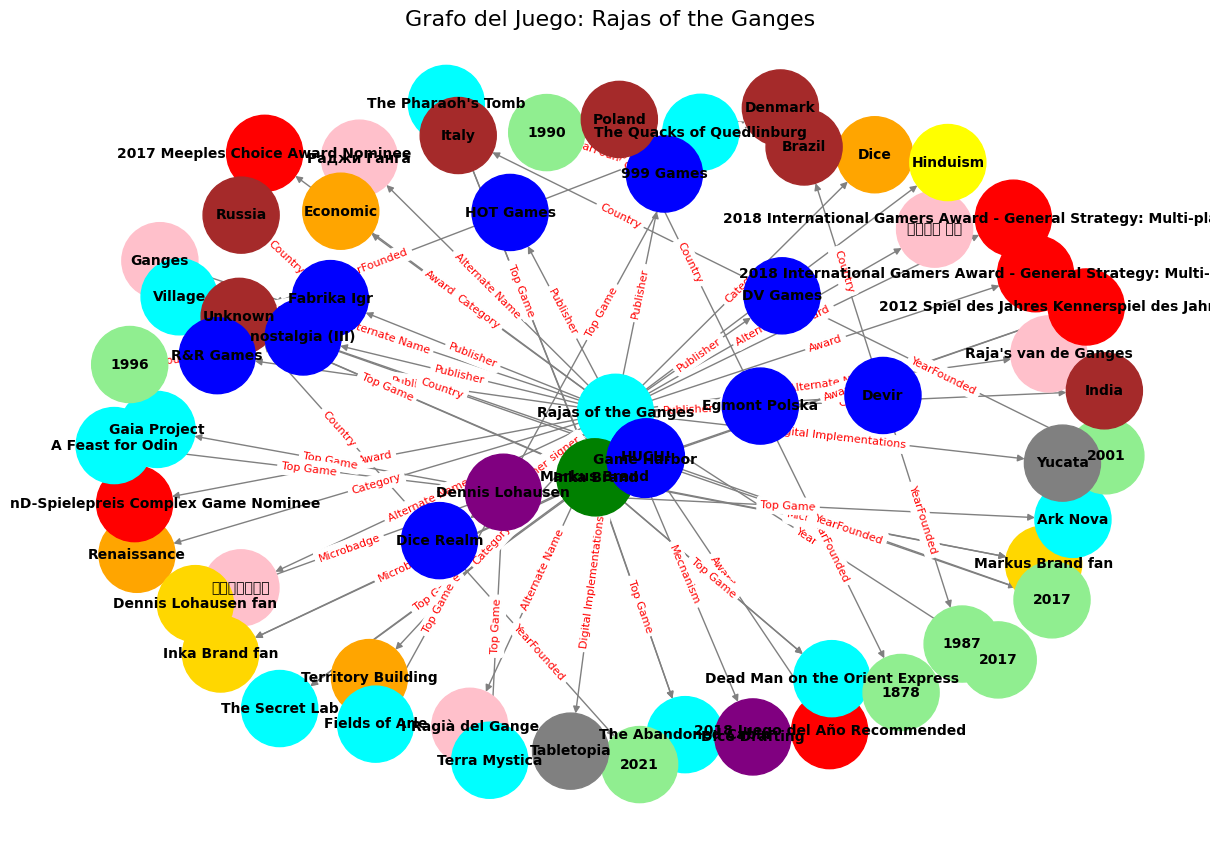

In [192]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar el nodo principal
main_node = game_data["Name"]
G.add_node(main_node, type="Main")

# Agregar nodos relacionados con atributos
# Año
G.add_node(game_data["Year"], type="Year")
G.add_edge(main_node, game_data["Year"], relation="Year")

# Nombres alternativos
for alt_name in game_data["AlternateNames"]:
    G.add_node(alt_name, type="AlternateName")
    G.add_edge(main_node, alt_name, relation="Alternate Name")

# Categorías
for category in game_data["Categories"]:
    G.add_node(category, type="Category")
    G.add_edge(main_node, category, relation="Category")

# Premios
for award in awards_data:
    G.add_node(award, type="Award")
    G.add_edge(main_node, award, relation="Award")

# Creadores (Designers)
# Agregar nodos relacionados con creadores
for creator in designers_data:
    creator_name = creator['Name']
    print(creator_name)
    G.add_node(creator_name, type='Creator')
    G.add_edge(main_node, creator_name, relation='Creator')

    # Agregar microbadges
    for badge_key in ['Microbadge1', 'Microbadge2']:
        if badge_key in creator:
            badge_name = creator[badge_key]['Name'].replace("Microbadge: ", "")
            G.add_node(badge_name, type='Microbadge')
            G.add_edge(creator_name, badge_name, relation='Microbadge')

    # Agregar premios
    for award in creator['Awards']:
        G.add_node(award, type='Award')
        G.add_edge(creator_name, award, relation='Award')

    # Agregar top games
    for game in creator['TopGames']:
        G.add_node(game, type='TopGame')
        G.add_edge(creator_name, game, relation='Top Game')

# Diseñadores (Artists)
# Agregar nodos relacionados con artistas
for designer in artists_data:
    designer_name = designer['Name']
    G.add_node(designer_name, type='Designer')
    G.add_edge(main_node, designer_name, relation='Designer')

    # Agregar microbadges
    for badge_key in ['Microbadge1', 'Microbadge2']:
        if badge_key in designer:
            badge_name = designer[badge_key]['Name'].replace("Microbadge: ", "")
            G.add_node(badge_name, type='Microbadge')
            G.add_edge(designer_name, badge_name, relation='Microbadge')

    # Agregar premios
    for award in designer['Awards']:
        G.add_node(award, type='Award')
        G.add_edge(designer_name, award, relation='Award')

    # Agregar top games
    for game in designer['TopGames']:
        G.add_node(game, type='TopGame')
        G.add_edge(designer_name, game, relation='Top Game')

# Editores
# Agregar nodos relacionados con publishers
for publisher in publishers_data:
    publisher_name = publisher['Name']
    G.add_node(publisher_name, type='Publisher')
    G.add_edge(main_node, publisher_name, relation='Publisher')

    # Agregar año de fundación si está presente
    if 'YearFounded' in publisher:
        year_founded = publisher['YearFounded']
        G.add_node(year_founded, type='Year')
        G.add_edge(publisher_name, year_founded, relation="YearFounded")

    # Agregar país si está presente
    if 'Country' in publisher:
        country = publisher['Country']
        G.add_node(country, type='Country')
        G.add_edge(publisher_name, country, relation="Country")

# Temas relacionados
for family in family_data:
    family_theme = family['Theme']
    family_name = family['Name']
    if family_theme != 'Game' and family_theme != 'Admin':
        G.add_node(family_name, type=family_theme)
        G.add_edge(main_node, family_name, relation=family_theme)


# Asignar colores según el tipo de nodo
color_map = {
    "Main": "skyblue",
    "Year": "lightgreen",
    "AlternateName": "pink",
    "Category": "orange",
    "Award": "red",
    'Creator': 'green',
    'Microbadge': 'gold',
    'TopGame': 'cyan',
    'Designer': 'purple',
    'Publisher': 'blue',
    "Country": "brown",
    "Digital Implementations": "gray",
    "Mechanism": "purple",
    "Religious": "yellow"
}

node_colors = [color_map[G.nodes[node]["type"]] if "type" in G.nodes[node] else "gray" for node in G.nodes]
# Dibujar el grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Posiciones para los nodos
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color=node_colors,
    font_size=10,
    font_weight="bold",
    edge_color="gray"
)

# Agregar etiquetas para las relaciones
edge_labels = nx.get_edge_attributes(G, "relation")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=8)

plt.title("Grafo del Juego: Rajas of the Ganges", fontsize=16)
plt.show()


In [ ]:
# Contar las conexiones de cada premio para ver si juego y diseñador comparten algún premio
for award in [node for node in G.nodes if G.nodes[node]["type"] == "Award"]:
    connected_nodes = list(G.neighbors(award))
    if len(connected_nodes) > 1:
        print(f"{award} is shared by: {connected_nodes}")

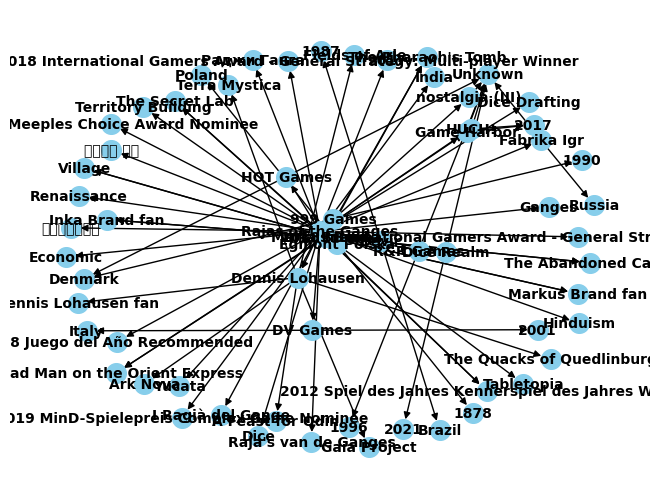

In [193]:
# Dibuja el grafo
nx.draw(G, with_labels=True, node_size=200, node_color='skyblue', font_size=10, font_weight='bold')
plt.show()


## Datos Tabulares

## Clasificador

### Basado en LLM

### Basado en un modelo entrenado con ejemplos y embeddings

# Ejercicio 2: Agente